In [ ]:
import pandas as pd;
from scipy.stats import zscore
import torch as torch;
import numpy as np
import torchvision.datasets as datasets
from torchvision import transforms
import torch.nn as nn;
import torch.nn.functional as F;
import torchvision.models as models

In [ ]:
np.random.seed(42)
#train on GPU if available. It will take a long time to train if done on CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#read in the dataset
num_classes=10;
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])
full_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True,
                             transform=transform )
full_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True,
                             transform=transform )

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
batch_size=64;
trainloader = torch.utils.data.DataLoader(full_train_dataset,
batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(full_test_dataset,
batch_size=batch_size,shuffle=False)

#Model 1

In [ ]:
# create a neural network (inherit from nn.Module)
class ConvNetWithBatchNorm(nn.Module):
    # architecture of the network is specified in the constructor
    def __init__(self):
        super(ConvNetWithBatchNorm, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3),
            nn.BatchNorm2d(num_features=12)
        )
        self.features1 = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(12*6*6, 50),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(50,num_classes)
        )

    # here we specify the computation (forward phase of training) how "x" is transfered into output "y"
    def forward(self, x):
        x = self.features(x)
        x = self.features1(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)
        # create an instance of the network
model=ConvNetWithBatchNorm().to(device);
criterion = F.nll_loss;
# this optimizer will do gradient descent for us
# experiment with learning rate and optimizer type
learning_rate = 0.001;
# note that we have to add all weights&biases, for both layers, to the optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
# we add a learning rate scheduler, which will modify the learning rate during training
# will initially start low, then increase it ("warm up"), and then gradually descrease it
n_epochs = 50;
num_updates = n_epochs*int(np.ceil(len(trainloader.dataset)/batch_size))
print(num_updates)
warmup_steps=1000;
def warmup_linear(x):
    if x < warmup_steps:
        lr=x/warmup_steps
    else:
        lr=max( (num_updates - x ) / (num_updates - warmup_steps), 0.)
    return lr;
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, warmup_linear);
accuracy1 = []
for i in range(n_epochs):
  batch_risk=0
  batches = 0
  for j, data in enumerate(trainloader):
      batches+=1
      inputs, labels = data
      inputs=inputs.to(device);
      labels=labels.to(device);

      optimizer.zero_grad();
      #forward phase - predictions by the model
      outputs = model(inputs);
      #forward phase - risk/loss for the predictions
      risk = criterion(outputs, labels);

      # calculate gradients
      risk.backward();

      # take the gradient step
      optimizer.step();
      scheduler.step();

      batch_risk+=risk.item();

  with (torch.no_grad()):
    correct = 0;
    for j, data in enumerate(testloader):

        inputs, labels = data
        inputs=inputs.to(device);
        labels=labels.to(device);
        outputs = model(inputs);
        pred = outputs.data.max(dim=1, keepdim=True)[1]
        correct += pred.eq(labels.data.view_as(pred)).sum().item();
  acc = correct / len(testloader.dataset)
  accuracy1.append(acc)
  print(i, batch_risk/batches, acc)

39100
0 1.8140361783144725 0.4485
1 1.4306864069245966 0.5125
2 1.3230896821564726 0.5343
3 1.2622538930010003 0.539
4 1.215456621268826 0.5564
5 1.1794579896475652 0.5696
6 1.1527551346270324 0.5796
7 1.125787546872483 0.5817
8 1.104610880774915 0.593
9 1.0883960209386734 0.5992
10 1.067265820320305 0.5904
11 1.053777236081755 0.5971
12 1.037896437870572 0.5987
13 1.0262172940137135 0.6002
14 1.014962653979621 0.6027
15 1.003900326655039 0.6105
16 0.9936360981305847 0.6076
17 0.9834785036876074 0.6084
18 0.9776194683273735 0.6101
19 0.9680789908789613 0.6088
20 0.9608886671798004 0.6082
21 0.9541787588992692 0.608
22 0.9446322422503205 0.6064
23 0.937560504431005 0.6145
24 0.9309765999884252 0.6193
25 0.9243441030497441 0.618
26 0.9158432252724152 0.6183
27 0.912910520039556 0.617
28 0.9076377480383724 0.6232
29 0.9056788564033216 0.617
30 0.897374197878801 0.6113
31 0.8906134314396802 0.6161
32 0.8890652516308952 0.6165
33 0.8800859841544305 0.6188
34 0.8764534587293025 0.6167
35 0.8

#RestNet18(pretrained=False)

In [ ]:
model2 = models.resnet18().to(device)
num_ftrs = model2.fc.in_features
model2.fc = nn.Linear(num_ftrs, num_classes).to(device)
criterion = nn.CrossEntropyLoss();
# this optimizer will do gradient descent for us
# experiment with learning rate and optimizer type
learning_rate = 0.001;
# note that we have to add all weights&biases, for both layers, to the optimizer
optimizer = torch.optim.Adam(model2.parameters(),lr=learning_rate)
# we add a learning rate scheduler, which will modify the learning rate during training
# will initially start low, then increase it ("warm up"), and then gradually descrease it
n_epochs = 50;
num_updates = n_epochs*int(np.ceil(len(trainloader.dataset)/batch_size))
print(num_updates)
warmup_steps=1000;
def warmup_linear(x):
    if x < warmup_steps:
        lr=x/warmup_steps
    else:
        lr=max( (num_updates - x ) / (num_updates - warmup_steps), 0.)
    return lr;
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, warmup_linear);
accuracy2 = []
for i in range(n_epochs):
  batch_risk=0
  batches =0
  for j, data in enumerate(trainloader):
      batches+=1
      inputs, labels = data
      inputs=inputs.to(device);
      labels=labels.to(device);

      optimizer.zero_grad();
      #forward phase - predictions by the model
      outputs = model2(inputs);
      #forward phase - risk/loss for the predictions
      risk = criterion(outputs, labels);

      # calculate gradients
      risk.backward();

      # take the gradient step
      optimizer.step();
      scheduler.step();

      batch_risk+=risk.item();

  with (torch.no_grad()):
    correct = 0;
    model2.eval()
    for j, data in enumerate(testloader):
        inputs, labels = data
        inputs=inputs.to(device);
        labels=labels.to(device);
        outputs = model2(inputs);
        pred = outputs.data.max(dim=1, keepdim=True)[1]
        correct += pred.eq(labels.data.view_as(pred)).sum().item();
  acc = correct / len(testloader.dataset)
  accuracy2.append(acc)
  print(i, batch_risk/batches, acc)

39100
0 1.5825931006075475 0.5331
1 1.235935520104435 0.6195
2 1.0105415783117495 0.6467
3 0.8776541633526688 0.6948
4 0.7565879235258492 0.6983
5 0.6579764960405162 0.7189
6 0.5635837641975764 0.6979
7 0.4735820624415222 0.7238
8 0.3836059057918351 0.728
9 0.31076249407837764 0.7177
10 0.2605049775036819 0.7211
11 0.210591087027279 0.7276
12 0.1710249341767081 0.7261
13 0.15423877527722923 0.7274
14 0.1270751587515387 0.7371
15 0.11147757205704842 0.7275
16 0.10546514738227247 0.726
17 0.08849992754731013 0.7299
18 0.08116416444839991 0.7286
19 0.07524487674069565 0.7329
20 0.06604592286257545 0.7402
21 0.06589855162663233 0.7303
22 0.047925051854839404 0.7301
23 0.05468759839744557 0.7275
24 0.0451078935263707 0.7374
25 0.03897455880713775 0.7342
26 0.03480113444325384 0.7332
27 0.03770135187426992 0.7283
28 0.027297367674705444 0.7379
29 0.025031460130529832 0.7385
30 0.023155894880748 0.7384
31 0.023051711204705897 0.7398
32 0.01789227825996969 0.7403
33 0.017307515227310066 0.7361

#RestNet18(pretrained=True)

In [ ]:
# RestNet18 (pretrained=True)
model3 = models.resnet18(pretrained=True).to(device)
num_ftrs = model3.fc.in_features
model3.fc = nn.Linear(num_ftrs, num_classes).to(device)
criterion = nn.CrossEntropyLoss();
# this optimizer will do gradient descent for us
# experiment with learning rate and optimizer type
learning_rate = 0.001;
# note that we have to add all weights&biases, for both layers, to the optimizer
optimizer = torch.optim.Adam(model3.parameters(),lr=learning_rate)
# we add a learning rate scheduler, which will modify the learning rate during training
# will initially start low, then increase it ("warm up"), and then gradually descrease it
n_epochs = 50;
num_updates = n_epochs*int(np.ceil(len(trainloader.dataset)/batch_size))
print(num_updates)
warmup_steps=1000;
def warmup_linear(x):
    if x < warmup_steps:
        lr=x/warmup_steps
    else:
        lr=max( (num_updates - x ) / (num_updates - warmup_steps), 0.)
    return lr;
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, warmup_linear);
accuracy3 = []
for i in range(n_epochs):
  batch_risk=0
  batches =0
  for j, data in enumerate(trainloader):
      batches+=1
      inputs, labels = data
      inputs=inputs.to(device);
      labels=labels.to(device);

      optimizer.zero_grad();
      #forward phase - predictions by the model
      outputs = model3(inputs);
      #forward phase - risk/loss for the predictions
      risk = criterion(outputs, labels);

      # calculate gradients
      risk.backward();

      # take the gradient step
      optimizer.step();
      scheduler.step();

      batch_risk+=risk.item();

  with (torch.no_grad()):
    correct = 0;
    for j, data in enumerate(testloader):
        inputs, labels = data
        inputs=inputs.to(device);
        labels=labels.to(device);
        outputs = model3(inputs);
        pred = outputs.data.max(dim=1, keepdim=True)[1]
        correct += pred.eq(labels.data.view_as(pred)).sum().item();
  acc = correct / len(testloader.dataset)
  accuracy3.append(acc)
  print(i, batch_risk/batches, acc)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

39100
0 1.0910372977595195 0.7366
1 0.7132821407769342 0.7649
2 0.5525761813763768 0.7859
3 0.4572642256727304 0.7867
4 0.3848690544552815 0.8019
5 0.30784687309352027 0.8044
6 0.2508232134925511 0.8061
7 0.19031724114628398 0.7949
8 0.15904827150242293 0.8104
9 0.13125167904145388 0.8123
10 0.11009679140839869 0.8076
11 0.09428407773589882 0.8053
12 0.08330110038000652 0.8051
13 0.07208926485413138 0.8073
14 0.06319822542956802 0.813
15 0.05213814282306301 0.8129
16 0.05198091426355136 0.8118
17 0.04068306848980532 0.8151
18 0.03968759712862426 0.8111
19 0.03669635993611637 0.8139
20 0.04253195565575889 0.8179
21 0.025689150666023213 0.8096
22 0.026018985278603426 0.8144
23 0.02343328069988772 0.8137
24 0.023100484109729962 0.8159
25 0.018715163224379418 0.8113
26 0.02047640376318189 0.8126
27 0.01599984298320956 0.8144
28 0.012386113060643147 0.8181
29 0.0124308114760643 0.8174
30 0.009774886581510746 0.8227
31 0.015831422386415567 0.8222
32 0.009229796846934582 0.8202
33 0.004735016

Text(0.5, 1.0, 'Accuracy vs training iterations')

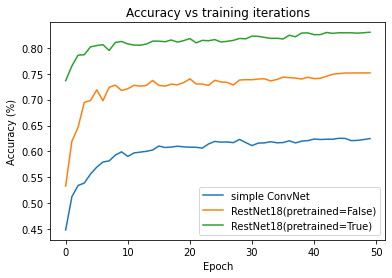

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(n_epochs), accuracy1, label = "simple ConvNet")
plt.plot(range(n_epochs), accuracy2, label = "RestNet18(pretrained=False)")
plt.plot(range(n_epochs), accuracy3, label = "RestNet18(pretrained=True)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy vs training iterations")

# Report:
We explore three convolutional neural networks based on the codes above. One is a simple convNet that was developed from the scratch. The other two models are based on the pre-trained RestNet18 model. We can see from the plot above that the pre-trained RestNet18 performs better than the simple ConvNet. We found that the pre-trained model exhibits more accuracy in a shorter amount of time using the same number of epochs and learning rate. Furthermore, among the three models, RestNet18(pretrained=True) performs the best.

#References:
1. https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
2. https://cs231n.github.io/transfer-learning/